create TopB-noReg dataset with external metabolite perturbations. 
Compare v-based results of 
- topB-noReg-allData
1. topB-noReg-allData + external metabolite perturbations
- topB-noReg-omitExMet
2. topB-noReg-omitExMet + external metabolite perturbations (this notebook)

# Set up 

In [1]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/omitted_data/')

## Perturbing enzymes

In [3]:
ant ='../../../models/Antimony/TopologyB.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.7241056990445864e-15

In [4]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x', '0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [5]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

## Leaving out external metabolite data

In [6]:
data01 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.1.csv')[enzymes+fluxes+internal]
data02 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.2.csv')[enzymes+fluxes+internal]
data03 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.3.csv')[enzymes+fluxes+internal]
data04 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.4.csv')[enzymes+fluxes+internal]
data05 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_0.5.csv')[enzymes+fluxes+internal]

data15 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_1.5.csv')[enzymes+fluxes+internal]
data3 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_3.csv')[enzymes+fluxes+internal]
data5 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_5.csv')[enzymes+fluxes+internal]
data7 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_7.csv')[enzymes+fluxes+internal]
data100 = pd.read_csv('../../../data/generated_data/TopologyB-noReg-exMet/TopologyB_10.csv')[enzymes+fluxes+internal]


In [7]:
BMCA_obj01 = antemll.antemll(ant, data01, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data02, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data03, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data04, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data3, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data5, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data7, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data100, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


# Running ADVI

In [8]:
def run_ADVI(BMCA_obj, n_samp=1):
    np.random.seed(SEED)
    random.seed(SEED)

    external = r.getBoundarySpeciesIds()
    
    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(external):
        if y in data100.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()

    with pm.Model() as pymc_model:

         # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=0.1, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))

        y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
        pm.Deterministic('y_t', y_t)
        
        chi_t = pm.Normal('chi_t', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        e_t = pm.Normal('e_t', mu=1, sigma=0.1, observed=BMCA_obj.en.squeeze().T)

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 45000

        advi = pm.ADVI(random_seed=1)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-2), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    
    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=SEED)

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 35,860


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 27,812


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 24,289


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 22,486


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 21,437


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 22,316


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 30,335


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 46,438


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 69,487


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.1781e+05


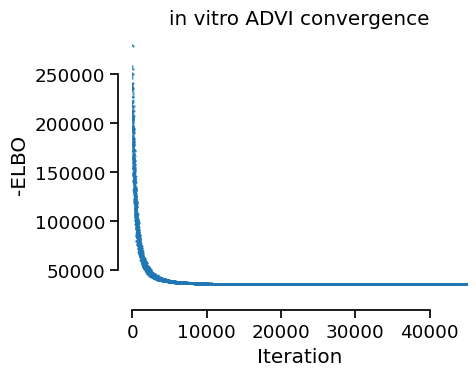

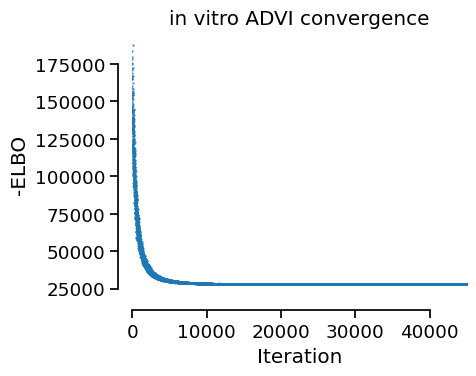

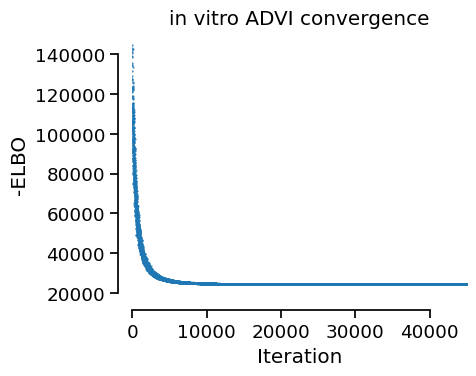

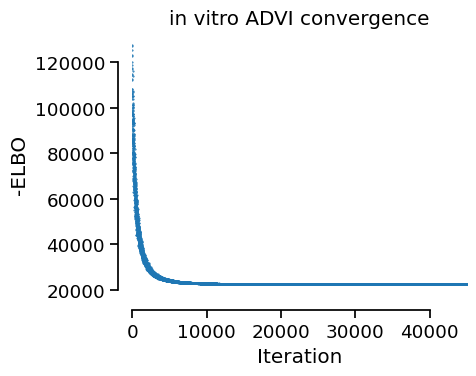

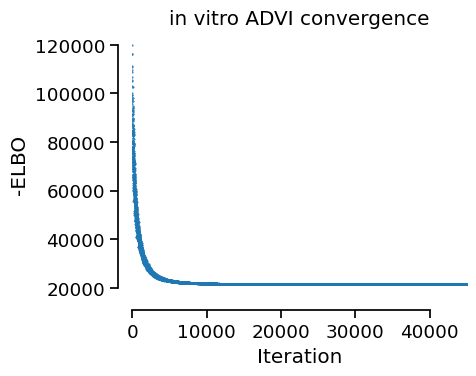

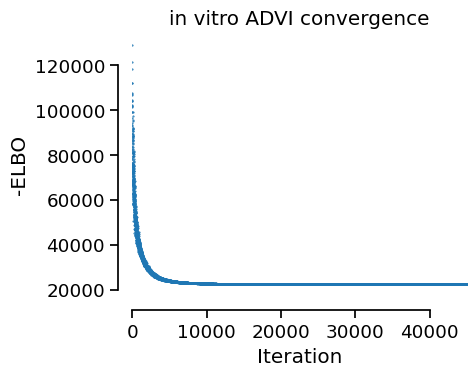

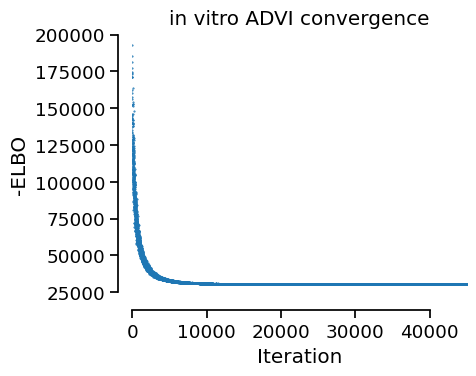

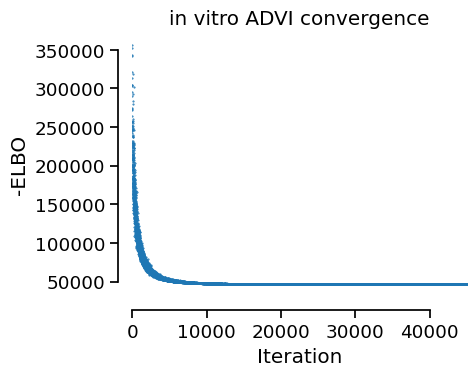

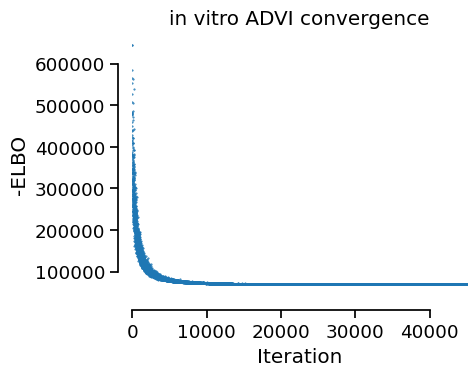

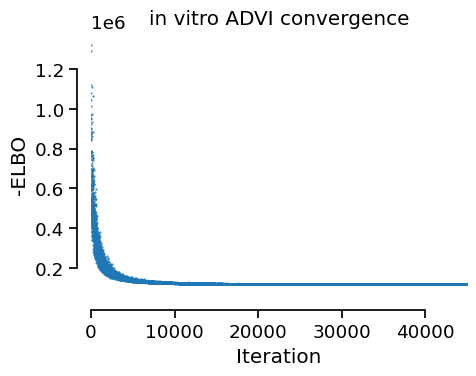

In [9]:
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)
trace05 = run_ADVI(BMCA_obj05)

trace15 = run_ADVI(BMCA_obj15)
trace3 = run_ADVI(BMCA_obj3)
trace5 = run_ADVI(BMCA_obj5)
trace7 = run_ADVI(BMCA_obj7)
trace100 = run_ADVI(BMCA_obj100)

### saving trace data

In [10]:
with gzip.open("../../../data/results/picklejar/dandelion-2.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100,

                },
                f,
            )

_go to `dandelion-stats.ipynb` and run that notebook for the results_